In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.model_selection import KFold

## Load the data

In [13]:
data = [
    json.loads(text)
    for text in open('data/train.json')
    
]
reactClasses = ['reactivity', 'deg_pH10', 'deg_Mg_pH10', 'deg_50C', 'deg_Mg_50C']
placeHolder = '*'
acceptableBases = ['A', 'G', 'U', 'C', placeHolder]

## Define Hyper Params

In [14]:
frameLength = 15
batchSize = 100
folds = 5
epochs = 8
learningRate = 0.0001

## Define Helper Functions

In [15]:
def getDataSet(indices, className, useFullSequence):
    records = [ data[i] for i in indices]
    featureSets = []
    labels = []
    for record in records:
        featureSets += extractFeatureSets(record, useFullSequence)
        labels += [[reactivity] for reactivity in record[className]]
    assert len(featureSets) == len(labels), f'length of featureSets: {len(featureSets)}, length of labels: {len(labels)}'
#     print(f'sample feature set: {featureSets[-10]}, sample label: {labels[-10]}')
    return RNADataSet(featureSets, labels)


def extractFeatureSets(record, useFullSequence):
    if useFullSequence:
        length = record['seq_length']
    else:
        length = record['seq_scored']
        
    bases = record['sequence']
    structure = record['structure']
    encodedBaseReadingFrames = encodeBaseReadingFrames(getBaseReadingFrames(bases[:length]))
    nestDepths = getNestDepths(structure)[:length]
    distances = getDistances(structure)[:length]
    clumping = getClumping(structure)[:length]
    
    return [
        encodedBaseReadingFrames[i] + [i, nestDepths[i], distances[i], clumping[i]]
        for i in range(length)
    ]

In [16]:
def encodeBaseReadingFrames(frames):
    encodings = []
    for frame in frames:
        encoding = []
        for actualBase in frame:
            for possibleBase in acceptableBases:
                if actualBase == possibleBase:
                    encoding.append(1)
                else:
                    encoding.append(0)
        encodings.append(encoding)
    return encodings

def getBaseReadingFrames(sequence, n=frameLength):
    assert n < len(sequence), 'cannot have framelength greater than sequence length'
    frames = []
    for i in range(len(sequence)):
        assert sequence[i] in acceptableBases, f'{sequence[i]} is not an acceptable base'
        if i < n - 1:
            numPadding = n - 1 - i
            frame = ''.join([placeHolder for i in range(numPadding)]) + sequence[0:i+1]
        else:
            frame = sequence[i - n + 1:i + 1]
        frames.append(frame)
    assert len(frames) == len(sequence), f'length of frames is {len(frames)}, length of sequence is {len(sequence)}'
    return frames


In [17]:
def getNestDepths(structure):
    currentDepth = 0
    depths = []
    for i in range(len(structure)):
        assert structure[i] == '(' or structure[i] == ')' or structure[i] == '.', 'Parings must be a "(", ")", or "."'
        if structure[i] == '(':
            currentDepth += 1
        elif i > 0 and structure[i-1] == ')':
            currentDepth -= 1
        depths.append(currentDepth)
    return depths
    

In [18]:
def getDistances(structure):
    distances = [0 for i in range(len(structure))]
    completed = [False for i in range(len(structure))]
    for i in range(len(structure)):
        if not completed[i]:
            if structure[i] == '.':
                completed[i] = True
            elif structure[i] == '(':
                j = i + 1
                numParen = 0
                while not (structure[j] == ')' and numParen == 0):
                    if structure[j] == '(':
                        numParen += 1
                    elif structure[j] == ')':
                        numParen -= 1
                    j += 1
                    assert j < len(structure), 'ill-formed sequence: j is beyond the max index'
                distance = j - i
                distances[i] = distance
                distances[j] = distance
                completed[i] = True
                completed[j] = True
    return distances

In [19]:
def getClumping(structure):
    clumping = [0 for i in range(len(structure))]
    i = 0
    while i < len(structure):
        if structure[i] != '.':
            j = i + 1
            while j < len(structure) and structure[j] != '.':
                j += 1
            clumpSize = j - i
            while i < j:
                clumping[i] = clumpSize
                i += 1
        else:
            i += 1
    return clumping

In [20]:
def train(model, optimizer, criteria, trainLoader, valLoader):
    trainLoss = []
    valLoss = []
    for epoch in range(epochs):
        
        # ****** Training *******
        model.train()
        losses = []
        for features, labels in trainLoader:
            optimizer.zero_grad()
            output = model(features)
            loss = criteria(output, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        trainLoss.append(np.mean(losses))
        
        # ****** Validation *******
        model.eval()
        losses = []
        with torch.no_grad():
            for features, labels in valLoader:
                optimizer.zero_grad()
                output = model(features)
                loss = criteria(output, labels)
                losses.append(loss.item())
            valLoss.append(np.mean(losses))
    return trainLoss, valLoss

In [21]:
class RNADataSet(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(np.array(features)).float()
        self.labels = torch.from_numpy(np.array(labels)).float()
    
    def __len__(self):
        return len(self.features)
    
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

## Describe the Distribution of the data

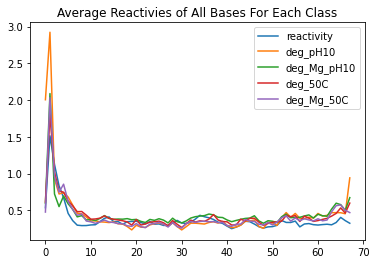

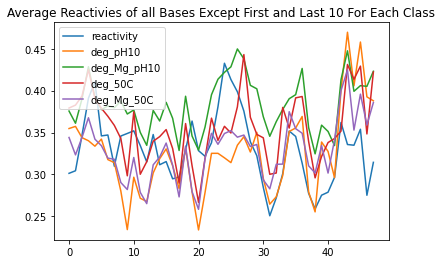

reactivity mean: 0.3749, std: 0.3749
deg_pH10 mean: 0.4469, std: 0.4469
deg_Mg_pH10 mean: 0.4463, std: 0.4463
deg_50C mean: 0.4259, std: 0.4259
deg_Mg_50C mean: 0.407, std: 0.407


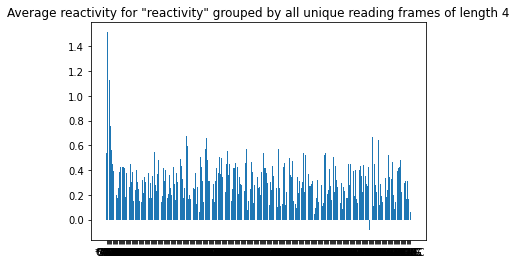

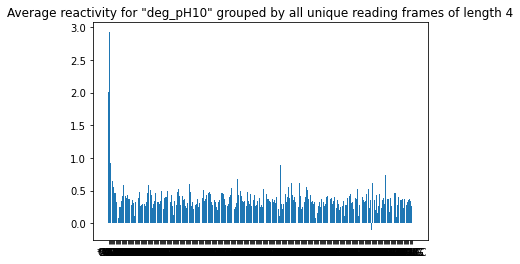

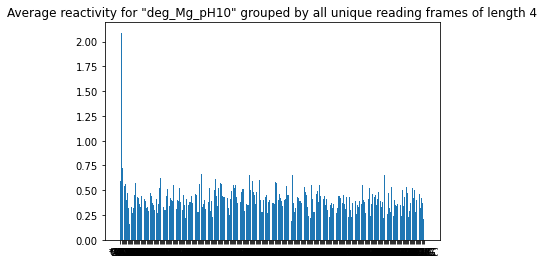

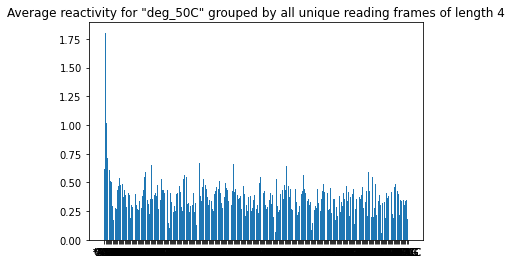

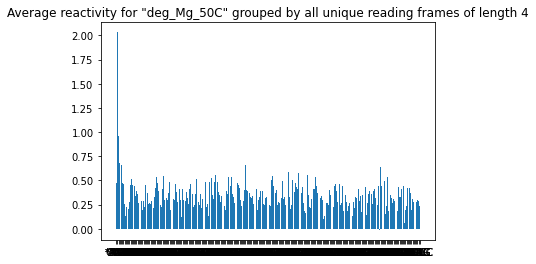

In [30]:
def getAverageReactivies(data, className):
    return np.mean(
        [record[className] for record in data ],
        axis=0
    )

def visualizeAverageNBases(reactivityClass, n):
    reactivitiesByFrame = {}
    for record in data:
        seq_scored = record['seq_scored']
        frames = getBaseReadingFrames(record['sequence'], n)[:seq_scored]
        reactivities = record[reactivityClass]
        assert len(reactivities) == len(frames)
        for i in range(len(frames)):
            if frames[i] not in reactivitiesByFrame.keys():
                reactivitiesByFrame[frames[i]] = [reactivities[i]]
            else:
                reactivitiesByFrame[frames[i]].append(reactivities[i])
    labels = [frame for frame in reactivitiesByFrame.keys()]
    averages = [ np.mean(reactivitiesByFrame[frame]) for frame in labels ]
    plt.bar(labels, averages)
    plt.title(f'Average reactivity for "{reactivityClass}" grouped by all unique reading frames of length {n}')
    plt.show()
    
averages = {
    className: getAverageReactivies(data, className)
    for className in reactClasses
}   

for className in reactClasses:
    plt.plot(averages[className], label=className)
plt.legend()
plt.title('Average Reactivies of All Bases For Each Class')
plt.show()

for className in reactClasses:
    plt.plot(averages[className][10:-10], label=className)
plt.legend()
plt.title('Average Reactivies of all Bases Except First and Last 10 For Each Class')
plt.show()

allReacts = {}
for className in reactClasses:
    reactivities = []
    for record in data:
        reactivities += record[className]
    allReacts[className] = reactivities

 

stats = {
    className: { 'mean': np.mean(allReacts[className]), 'std': np.mean(allReacts[className])}
    for className in reactClasses
}
for className in reactClasses:
    print(f'{className} mean: {round(stats[className]["mean"], 4)}, std: {round(stats[className]["std"], 4)}')

readingFrameLength = 4
for className in reactClasses:
    visualizeAverageNBases(className, readingFrameLength)

In [ ]:
className = 'reactivity'
splitter = KFold(folds)
allTrainLosses = []
allValLosses = []
foldCounter = 1
useFullSequence = False
for trainIndices, valIndices in splitter.split(data):
    trainData = getDataSet(trainIndices, className, useFullSequence)
    valData = getDataSet(valIndices, className, useFullSequence)
    trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
    valLoader = DataLoader(valData, batch_size=batchSize, shuffle=True)
    numFeatures = len(trainData[0][0])
    model = torch.nn.Linear(numFeatures, 1)
    criteria = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    trainLosses, valLosses = train(model, optimizer, criteria, trainLoader, valLoader)
    allTrainLosses.append(trainLosses)
    allValLosses.append(valLosses)
    print(f'Fold {foldCounter} last-epoch training: {round(trainLosses[-1], 4)}, validation: {round(valLosses[-1], 4)}')
    if foldCounter == 1:
        plt.title('Fold-1 Losses')
        plt.plot(trainLosses, label='Training')
        plt.plot(valLosses, label='Validation')
        plt.legend()
        plt.show()
    foldCounter += 1

In [ ]:
# print(allTrainLosses)
# print(allValLosses)
startingEpoch = 1
averageTrainLosses = []
averageValLosses = []
for i in range(epochs)[startingEpoch:]:
    averageTrainLosses.append(np.mean([loss[i] for loss in allTrainLosses]))
    averageValLosses.append(np.mean([loss[i] for loss in allValLosses]))
plt.plot(averageTrainLosses, label='Training')
plt.plot(averageValLosses, label='Validation')
plt.title(f'Average MSE over {folds}-fold cross validation after second epoch')
plt.legend()
plt.show()
print(f'Final average training error: {round(np.sqrt(averageTrainLosses[-1]), 4)}')
print(f'Final average validation error: {round(np.sqrt(averageValLosses[-1]), 4)}')
print("*****\n*****")